In [9]:
import os
import random
from deepface import DeepFace
import pandas as pd
from tqdm import tqdm
import json


In [10]:
# Get all identity folders
identity_folders = os.listdir('../identities_dataset')
# Randomly select 2000 folders
selected_folders = random.sample(identity_folders, 1000)

# Dictionary to store results
results = {}

# Process each selected folder
for i, folder in enumerate(tqdm(selected_folders)):
    folder_path = os.path.join('../identities_dataset', folder)
    # Get first image from folder
    images = os.listdir(folder_path)
    if images:  # Check if folder is not empty
        image_path = os.path.join(folder_path, images[0])
        try:
            # Analyze face
            analysis = DeepFace.analyze(image_path, actions=['age', 'gender', 'race'])
            if isinstance(analysis, list):
                analysis = analysis[0]
            
            # Store results
            results[folder] = {
                'ethnicity': max(analysis['race'].items(), key=lambda x: x[1])[0],
                'under_30': analysis['age'] < 30,
                'gender': analysis['gender']
            }
        except:
            continue
    
    # Save results every 1000 identities
    if (i + 1) % 10 == 0:
        with open(f'results_checkpoint.json', 'w') as f:
            json.dump(results, f)


100%|██████████| 1000/1000 [10:36<00:00,  1.57it/s]


In [43]:
with open('results_checkpoint.json', 'r') as f:
    results = json.load(f)

In [44]:
under_30_count = sum(1 for v in results.values() if v['under_30'])

# Calculate statistics
ethnicities = pd.DataFrame([v['ethnicity'] for v in results.values()]).value_counts()
gender_counts = {'Male': 0, 'Female': 0}
for v in results.values():
    if v["gender"]["Man"] > 0.5:
        gender_counts["Male"] += 1
    else:
        gender_counts["Female"] += 1

print("\nEthnicity Distribution:")
print(ethnicities)
print("\nGender Distribution:")
print(f"Male: {gender_counts['Male']}")
print(f"Female: {gender_counts['Female']}")
print(f"\nNumber of people under 30: {under_30_count}")
print(f"Number of people 30 and above: {len(results) - under_30_count}")


Ethnicity Distribution:
0              
white              502
asian              142
black               85
middle eastern      84
latino hispanic     74
indian              26
Name: count, dtype: int64

Gender Distribution:
Male: 738
Female: 175

Number of people under 30: 334
Number of people 30 and above: 579


In [45]:
# Parameters
target_ethnicities = ['indian', 'white', 'black', 'middle eastern', 'asian']
pairs_per_ethnicity = 50
identities_root = '../identities_dataset'

# Initialize separate lists for different categories
pairs = []
indian_pairs = []
white_pairs = []
black_pairs = []
middle_eastern_pairs = []
asian_pairs = []
male_pairs = []
female_pairs = []

# Prepare: group eligible identities by ethnicity
eligible = {eth: [] for eth in target_ethnicities}
for identity, info in results.items():
    eth = info['ethnicity'].lower()
    if eth in eligible and info['under_30']:
        if info["gender"]["Man"] > 0.8:
            info["gender"] = "Male"
        elif info["gender"]["Woman"] > 0.8:
            info["gender"] = "Female" 
        else:
            continue       
        eligible[eth].append((identity, info))

for eth in target_ethnicities:
    random.shuffle(eligible[eth])
    count = 0
    for identity, info in eligible[eth]:
        folder = os.path.join(identities_root, identity)
        images = os.listdir(folder)
        if len(images) < 3:  # Need at least 3 images (1 anchor, 2 positive)
            continue
        
        # Select anchor and two positive images
        anchor_img = random.choice(images)
        remaining_images = [img for img in images if img != anchor_img]
        positive_imgs = random.sample(remaining_images, 2)
        
        # Find two negatives
        candidates = [
            (neg_id, neg_info) for neg_id, neg_info in eligible[eth]
            if neg_id != identity and neg_info['gender'] == info['gender']
        ]
        if len(candidates) < 2:
            continue
            
        negative_identities = random.sample(candidates, 2)
        current_pairs = []
        
        for i in range(2):
            anchor_path = os.path.join(folder, anchor_img)
            positive_path = os.path.join(folder, positive_imgs[i])
            
            neg_identity, _ = negative_identities[i]
            neg_folder = os.path.join(identities_root, neg_identity)
            neg_images = os.listdir(neg_folder)
            if not neg_images:
                continue
            negative_img = random.choice(neg_images)
            negative_path = os.path.join(neg_folder, negative_img)
            
            pair = (anchor_path, positive_path, negative_path, identity, neg_identity)
            current_pairs.append(pair)
        
        if len(current_pairs) == 2:
            pairs.extend(current_pairs)
            # Add to specific ethnicity lists
            if eth == 'indian':
                indian_pairs.extend(current_pairs)
            elif eth == 'white':
                white_pairs.extend(current_pairs)
            elif eth == 'black':
                black_pairs.extend(current_pairs)
            elif eth == 'middle eastern':
                middle_eastern_pairs.extend(current_pairs)
            elif eth == 'asian':
                asian_pairs.extend(current_pairs)
                
            # Add to gender-specific lists
            if info['gender'] == 'Male':
                male_pairs.extend(current_pairs)
            else:
                female_pairs.extend(current_pairs)
                
            count += 1
            if count >= pairs_per_ethnicity:
                break

print(f"Total pairs generated: {len(pairs)}")
print(f"Indian pairs: {len(indian_pairs)}")
print(f"White pairs: {len(white_pairs)}")
print(f"Black pairs: {len(black_pairs)}")
print(f"Middle Eastern pairs: {len(middle_eastern_pairs)}")
print(f"Asian pairs: {len(asian_pairs)}")
print(f"Male pairs: {len(male_pairs)}")
print(f"Female pairs: {len(female_pairs)}")

Total pairs generated: 296
Indian pairs: 6
White pairs: 100
Black pairs: 66
Middle Eastern pairs: 46
Asian pairs: 78
Male pairs: 268
Female pairs: 28


In [46]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import yaml
from matplotlib import pyplot as plt


from iresnet import iresnet100  # or your custom path if you cloned insightface locally

# Load YAML
# with open('ms1mv3_arcface_r100_fp16/model.yaml', 'r') as f:
#     config = yaml.safe_load(f)

# Create model
model = iresnet100(pretrained=False)
model.load_state_dict(torch.load('../ms1mv3_arcface_r100_fp16/backbone.pth', map_location='cpu'))
model.eval()

import cv2
import numpy as np
import torch

def preprocess(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Image not found at {img_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (112, 112))
    img = np.transpose(img, (2, 0, 1))  # Channels first: (3, 112, 112)
    img = img.astype(np.float32)
    img = (img / 255.0 - 0.5) / 0.5  # Normalize
    img = torch.from_numpy(img)      # <-- CONVERT numpy -> torch.Tensor
    img = img.unsqueeze(0)           # Add batch dimension: (1, 3, 112, 112)
    return img, img_rgb


# Step 4: Inference function
def get_embedding(img_path):
    img_tensor, rgb = preprocess(img_path)
    with torch.no_grad():
        emb = model(img_tensor)
        emb = F.normalize(emb, p=2, dim=1)
    return emb, rgb

# Step 5: Compare two embeddings
def compare_embeddings(emb1, emb2, threshold=0.5):
    similarity = F.cosine_similarity(emb1, emb2).item()
    print(f"Cosine Similarity: {similarity:.4f}")
    if similarity > threshold:
        print("Result: SAME PERSON ✅")
    else:
        print("Result: DIFFERENT PERSON ❌")
    return similarity


def plot_images(img1, img2, similarity):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img1)
    axs[0].axis('off')
    axs[0].set_title('Image 1')

    axs[1].imshow(img2)
    axs[1].axis('off')
    axs[1].set_title('Image 2')

    plt.suptitle(f'Cosine Similarity: {similarity:.4f}', fontsize=16)
    plt.tight_layout()
    plt.show()

In [51]:
import pytest
import torch

def calculate_accuracy(pairs_list, threshold=0.5):
    """Calculate accuracy for a list of pairs."""
    correct = 0
    total = 0
    
    for pair in pairs_list:
        anchor_path, pos_path, neg_path = pair[0], pair[1], pair[2]
        
        # Get embeddings
        anchor_emb, _ = get_embedding(anchor_path)
        pos_emb, _ = get_embedding(pos_path)
        neg_emb, _ = get_embedding(neg_path)
        
        # Calculate similarities
        pos_sim = torch.nn.functional.cosine_similarity(anchor_emb, pos_emb).item()
        neg_sim = torch.nn.functional.cosine_similarity(anchor_emb, neg_emb).item()
        
        # Check if predictions are correct
        if pos_sim > threshold and neg_sim < threshold:
            correct += 1
        
        total += 1
    
    return correct / total if total > 0 else 0

def test_overall_accuracy():
    """Test accuracy on the entire dataset."""
    accuracy = calculate_accuracy(pairs)
    print(f"\nOverall accuracy: {accuracy:.4f}")
    assert accuracy > 0.5, "Overall accuracy should be better than random chance"

def test_ethnicity_accuracies():
    """Test accuracy for each ethnicity subset."""
    ethnicity_pairs = {
        'indian': indian_pairs,
        'white': white_pairs,
        'black': black_pairs,
        'middle_eastern': middle_eastern_pairs,
        "asian": asian_pairs
    }
    
    for ethnicity, subset_pairs in ethnicity_pairs.items():
        accuracy = calculate_accuracy(subset_pairs)
        print(f"{ethnicity.capitalize()} accuracy: {accuracy:.4f}")
        assert accuracy > 0.4, f"{ethnicity.capitalize()} accuracy should be reasonable"

def test_gender_accuracies():
    """Test accuracy for each gender subset."""
    gender_accuracies = {
        'male': calculate_accuracy(male_pairs),
        'female': calculate_accuracy(female_pairs)
    }
    
    for gender, accuracy in gender_accuracies.items():
        print(f"{gender.capitalize()} accuracy: {accuracy:.4f}")
        assert accuracy > 0.4, f"{gender.capitalize()} accuracy should be reasonable"

def test_dataset_sizes():
    """Test that all subset sizes add up correctly."""
    # Test ethnicity subsets
    total_ethnicity_pairs = len(indian_pairs) + len(white_pairs) + len(black_pairs) + len(middle_eastern_pairs) + len(asian_pairs)
    assert total_ethnicity_pairs == len(pairs), "Ethnicity subsets should sum to total pairs"
    
    # Test gender subsets
    assert len(male_pairs) + len(female_pairs) == len(pairs), "Gender subsets should sum to total pairs"

def test_pair_structure():
    """Test that pairs are properly structured."""
    for pair in pairs:
        assert len(pair) == 5, "Each pair should have 5 elements"
        assert isinstance(pair[0], str), "First element should be anchor path"
        assert isinstance(pair[1], str), "Second element should be positive path"
        assert isinstance(pair[2], str), "Third element should be negative path"
        assert isinstance(pair[3], str), "Fourth element should be anchor identity"
        assert isinstance(pair[4], str), "Fifth element should be negative identity"
        assert pair[3] != pair[4], "Anchor and negative identities should be different"

In [52]:
test_pair_structure()

In [53]:
test_dataset_sizes()

In [37]:
test_gender_accuracies()

Male accuracy: 0.9214
Female accuracy: 1.0000


In [54]:
test_ethnicity_accuracies()

Indian accuracy: 0.8333
White accuracy: 0.9100
Black accuracy: 0.8788
Middle_eastern accuracy: 0.8913
Asian accuracy: 0.9615


In [55]:
test_overall_accuracy()


Overall accuracy: 0.9122


Positive pair:
Cosine Similarity: 0.7064
Result: SAME PERSON ✅


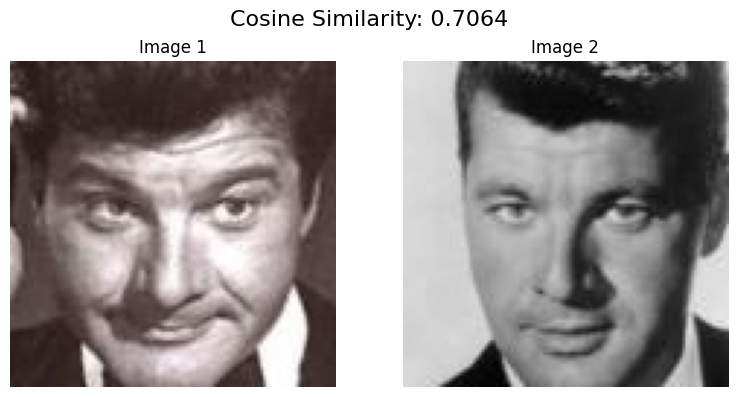

Negative pair:
Cosine Similarity: -0.0143
Result: DIFFERENT PERSON ❌


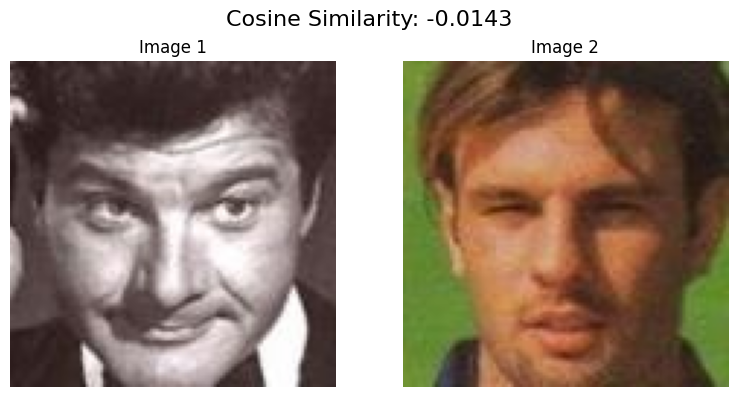

Positive pair:
Cosine Similarity: 0.6753
Result: SAME PERSON ✅


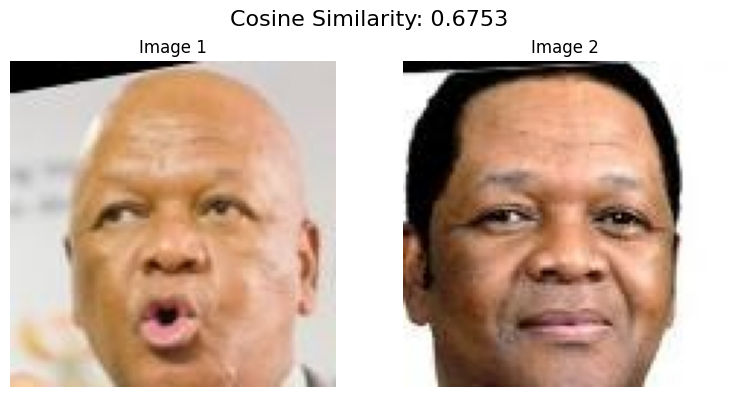

Negative pair:
Cosine Similarity: -0.0373
Result: DIFFERENT PERSON ❌


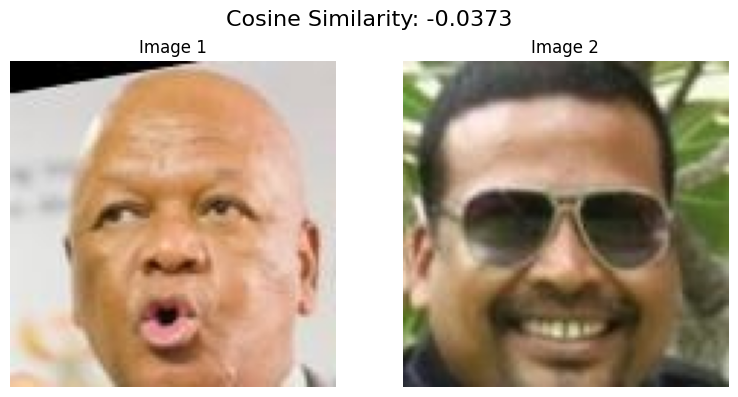

Positive pair:
Cosine Similarity: 0.5526
Result: SAME PERSON ✅


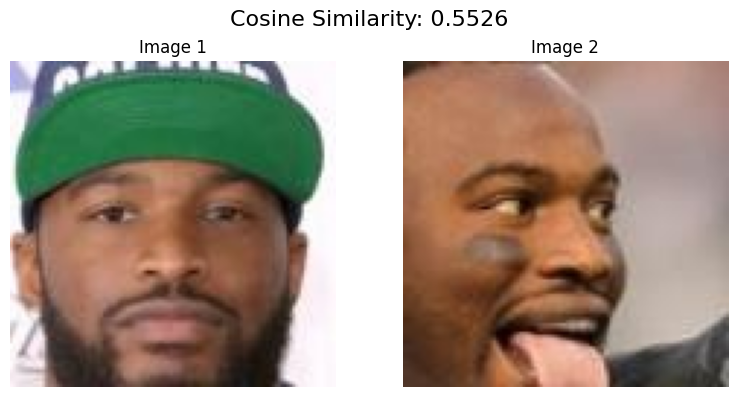

Negative pair:
Cosine Similarity: -0.1283
Result: DIFFERENT PERSON ❌


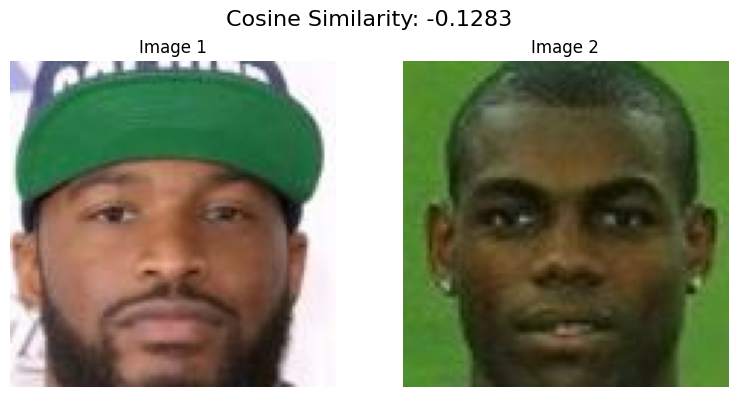

Positive pair:
Cosine Similarity: 0.7088
Result: SAME PERSON ✅


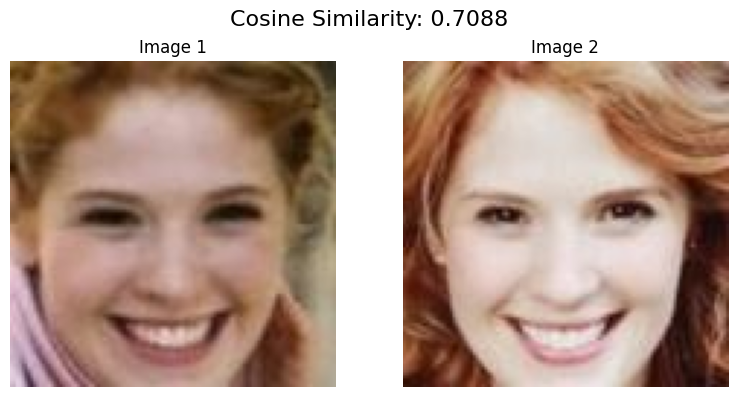

Negative pair:
Cosine Similarity: 0.0992
Result: DIFFERENT PERSON ❌


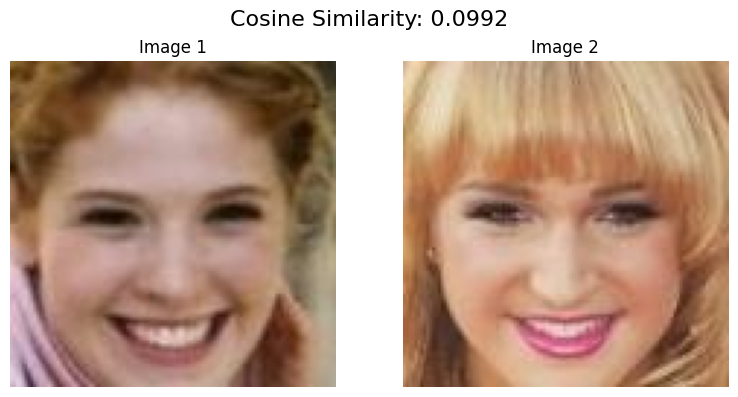

Positive pair:
Cosine Similarity: 0.7754
Result: SAME PERSON ✅


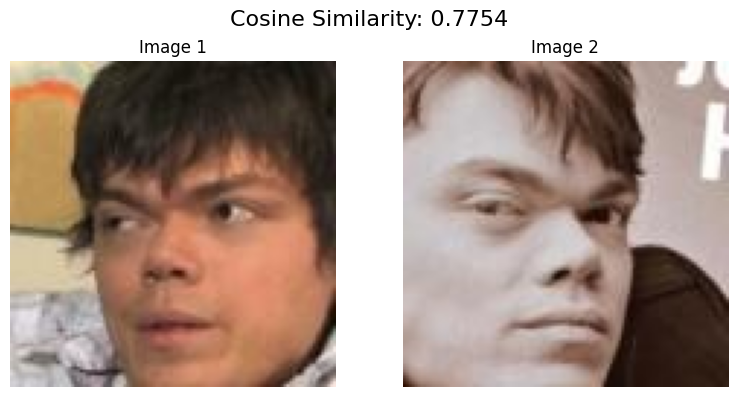

Negative pair:
Cosine Similarity: 0.0575
Result: DIFFERENT PERSON ❌


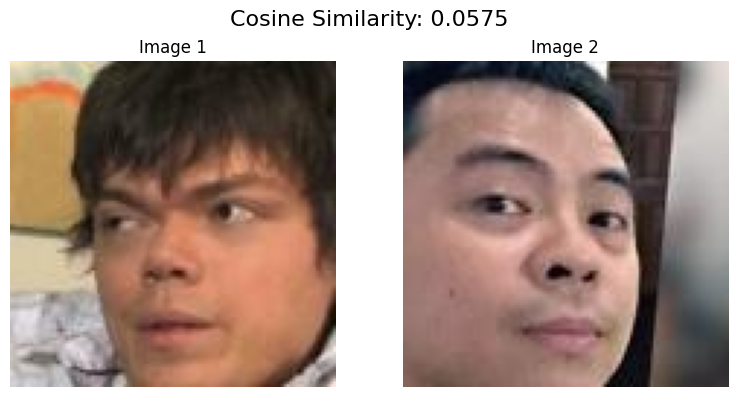

In [56]:
five_pairs = random.sample(pairs, 5)

for pair in five_pairs:

    embedding_anchor, rgb1 = get_embedding(pair[0])
    embedding_pos, rgb2 = get_embedding(pair[1])
    embedding_neg, rgb3 = get_embedding(pair[2])

    print("Positive pair:")
    plot_images(rgb1, rgb2, compare_embeddings(embedding_anchor, embedding_pos))
    print("Negative pair:")
    plot_images(rgb1, rgb3, compare_embeddings(embedding_anchor, embedding_neg))
